In [9]:
import numpy as np
from scipy.linalg import lstsq
from scipy.special import hankel1, jv
import matplotlib.pyplot as plt

In [10]:
# Parameters
k = 12       # wavenumber
N = 500      # number of source points
M = 500      # number of boundary points
R = 0.8      # radius for fictitious sources (< 1 for exterior problem)
nmax = 100   # number of terms in series expansion for the exact sol

# Incident field (plane wave traveling in the positive x-direction)
def u_inc(z):
    return np.exp(1j * k * z.real)

In [11]:
# Source points
theta_j = np.linspace(0, 2 * np.pi, N, endpoint=False)
y = R * np.exp(1j * theta_j)

# Boundary points
theta_i = np.linspace(0, 2 * np.pi, M, endpoint=False)
x = np.exp(1j * theta_i)

# Form matrix A
r = np.abs(x[:, None] - y)
A = hankel1(0, k * r)

# Solve least-squares problem for alpha
alpha, _, _, _ = lstsq(A, -u_inc(x))

In [12]:
# Create evaluation grid
grid = np.linspace(-1.5, 1.5, 300)
X, Y = np.meshgrid(grid, grid)
Z = X + 1j * Y

# Compute u_sc^(N)
u_sc = (alpha * hankel1(0, k * np.abs(Z[:, :, None] - y))).sum(axis=2)

# Total field is the sum of the incident and scattered fields
u_tot = u_inc(Z) + u_sc

In [5]:
# Compute the exact solution using a series expansion
# for scattering by a sound–soft disc.

# We vectorise the summation over modes n = -nmax, …, nmax.
r_grid = np.abs(Z)
theta_grid = np.angle(Z)
n_arr = np.arange(-nmax, nmax+1)[:, None, None]  # (2*nmax+1, 1, 1)

# Compute the Bessel and Hankel functions for each mode:
J_n_kr   = jv(n_arr, k * r_grid)            # (2*nmax+1, grid, grid)
J_n_k    = jv(n_arr, k)                     # (2*nmax+1, 1, 1)
H_n1_k   = hankel1(n_arr, k)                # (2*nmax+1, 1, 1)
H_n1_kr  = hankel1(n_arr, k * r_grid)       # (2*nmax+1, grid, grid)

# Compute the modal contributions and sum over n
u_exact = np.sum((1j)**n_arr * (J_n_kr - (J_n_k / H_n1_k) * H_n1_kr)
                  * np.exp(1j * n_arr * theta_grid), axis=0)

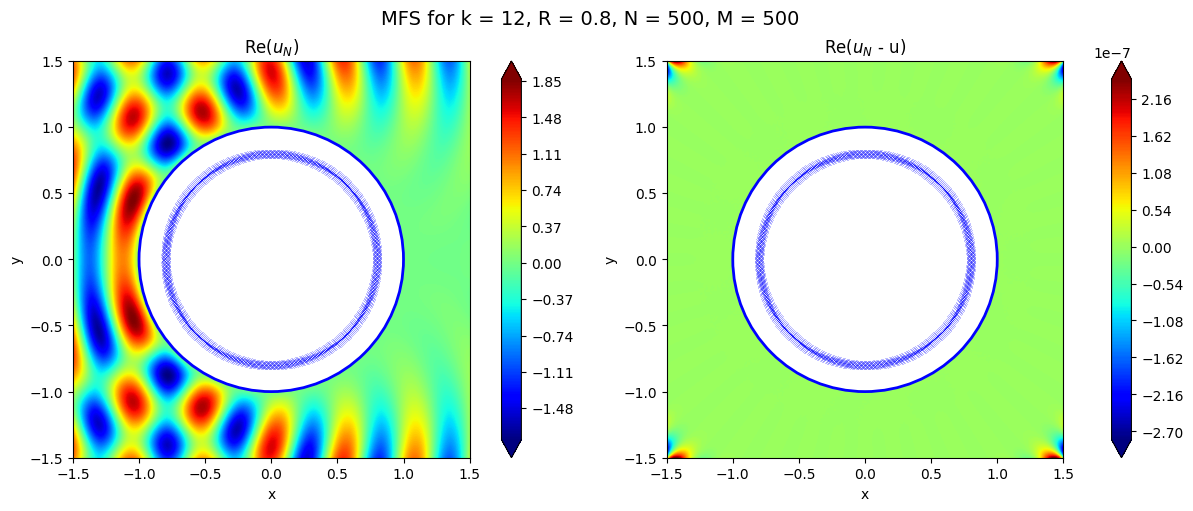

In [13]:
# Mask the unit disc interior (solution valid for r>=1)
mask = r_grid >= 1.0
u_tot_masked = np.where(mask, u_tot, np.nan)
u_exact_masked = np.where(mask, u_exact, np.nan)
error = u_tot_masked - u_exact_masked

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5),
                               constrained_layout=True)
fig.suptitle(f"MFS for k = {k}, R = {R}, N = {N}, M = {M}", fontsize=14)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
opts = {"levels": 400, "cmap": "jet", "extend": "both"}

# Plot MFS approximation
cf1 = ax1.contourf(X, Y, np.real(u_tot_masked), **opts)
fig.colorbar(cf1, ax=ax1)
ax1.set_title("Re($u_N$)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.add_patch(plt.Circle((0, 0), 1, color='blue', fill=False, lw=2))
ax1.scatter(np.real(y), np.imag(y), color='blue',
            marker='x', linewidths=0.2)

# Plot error from exact series solution
cf2 = ax2.contourf(X, Y, np.real(error), **opts)
fig.colorbar(cf2, ax=ax2)
ax2.set_title("Re($u_N$ - u)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.add_patch(plt.Circle((0, 0), 1, color='blue', fill=False, lw=2))
ax2.scatter(np.real(y), np.imag(y), color='blue',
            marker='x', linewidths=0.2)

plt.show()